In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import yfinance as yf
maindf = yf.download('BTC-USD')

[*********************100%***********************]  1 of 1 completed


In [ ]:
#changing dataset to simulate different days
goBack = 14

maindf = maindf[:len(maindf) - goBack]


In [ ]:
testSize = 30
trainSize = 365
#trainSize = len(maindf) - testSize

maindf = maindf[len(maindf) - trainSize - testSize:len(maindf)]

Total number of days present in the Main dataset:  395
Total number of fields present in the Main dataset:  6


Total number of days present in the dataset:  395
Total number of fields present in the dataset:  1
                   Close
Date                    
2022-11-27  16444.626953
2022-11-28  16217.322266
2022-11-29  16444.982422
2022-11-30  17168.566406
2022-12-01  16967.132812


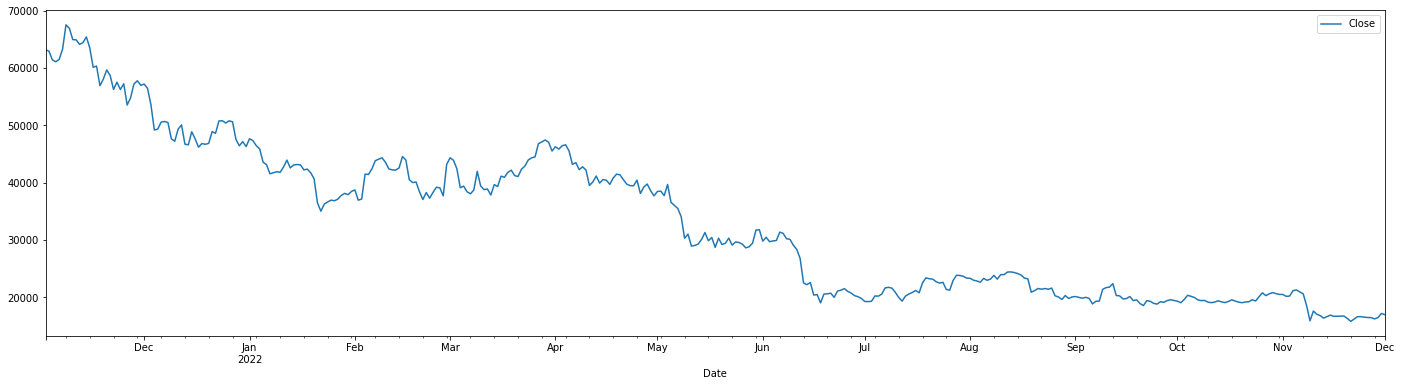

In [ ]:
#SHAPE of the dataset
print('Total number of days present in the Main dataset: ',maindf.shape[0]) #rows
print('Total number of fields present in the Main dataset: ',maindf.shape[1]) #cols
#print('\n',maindf.info())

df = maindf[['Close']] # we are only interested in the closing price
print('\n\nTotal number of days present in the dataset: ',df.shape[0])
print('Total number of fields present in the dataset: ',df.shape[1])
#print('\n',df.info())

df.plot(figsize = (24,6))

print(df.tail())

In [ ]:

train = df.iloc[ : len(df) - testSize]
test = df.iloc[-testSize : ]

print(train.tail())
print(test.head())

                   Close
Date                    
2022-10-28  20595.351562
2022-10-29  20818.476562
2022-10-30  20635.603516
2022-10-31  20495.773438
2022-11-01  20485.273438
                   Close
Date                    
2022-11-02  20159.503906
2022-11-03  20209.988281
2022-11-04  21147.230469
2022-11-05  21282.691406
2022-11-06  20926.486328


In [ ]:
#Normalizing the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(train) 
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

import pandas as pd

df_scaled_train = pd.DataFrame(data = scaled_train, 
                  index = train.index, 
                  columns = ['Close'])

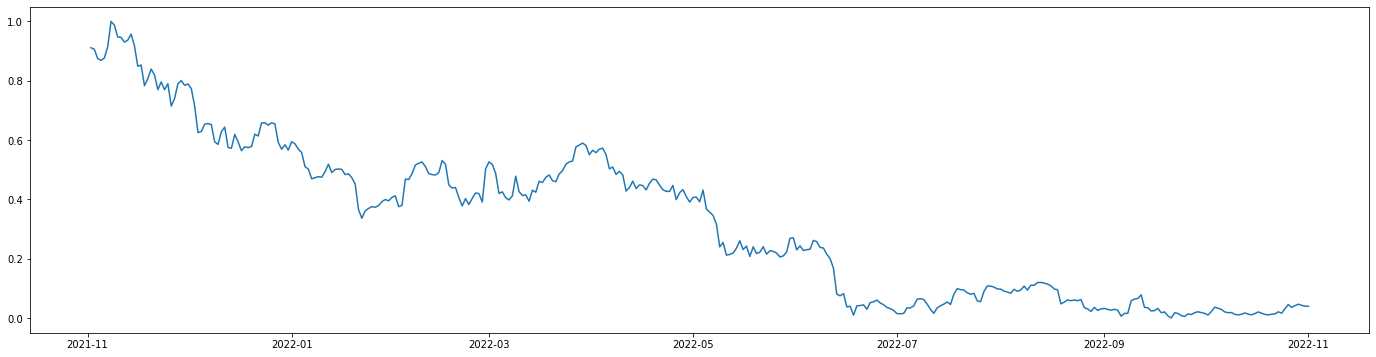

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(24, 6))      
plt.plot(df_scaled_train['Close'])
plt.show()

In [ ]:
#Augmented Dickey fuller test for Sationarity

from statsmodels.tsa.stattools import adfuller #import the augmenetd dickey fuller
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC') 
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:", dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)


adf_test(df_scaled_train['Close'])  #We see that p-value > 0.05
#so our bitcoin price series is not stationary, so we will need to do differencing

1. ADF :  -1.9665122073837937
2. P-Value :  0.3014465326980093
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 364
5. Critical Values :
	 1% :  -3.4484434475193777
	 5% :  -2.869513170510808
	 10% :  -2.571017574266393


1. ADF :  -18.66384307019048
2. P-Value :  2.046777246594148e-30
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 363
5. Critical Values :
	 1% :  -3.448493650810824
	 5% :  -2.8695352280356556
	 10% :  -2.5710293341377715
(395, 1)
(364, 1)
                   Close
Date                    
2021-11-02  63226.402344
2021-11-03  62970.046875
2021-11-04  61452.230469
2021-11-05  61125.675781
2021-11-06  61527.480469
...                  ...
2022-11-27  16444.626953
2022-11-28  16217.322266
2022-11-29  16444.982422
2022-11-30  17168.566406
2022-12-01  16967.132812

[395 rows x 1 columns]
               Close
Date                
2021-11-03 -0.005230
2021-11-04 -0.030964
2021-11-05 -0.006662
2021-11-06  0.008197
2021-11-07  0.036710
...              ...
2022-10-28  0.006314
2022-10-29  0.004552
2022-10-30 -0.003731
2022-10-31 -0.002853
2022-11-01 -0.000214

[364 rows x 1 columns]


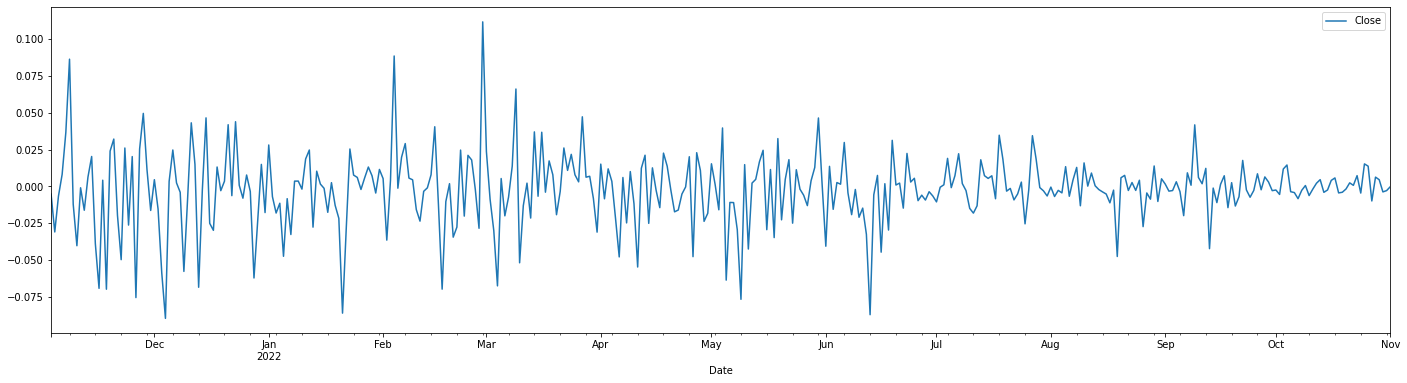

In [ ]:
#Finding d
#i.e, the order of difrencing needed in ARIMA

df_diff_1 = df_scaled_train.diff()[1:]; #first differencing
#after first differencing, we are getting our p-value < 0.05, so no more differencing is needed;
adf_test(df_diff_1); 

df_diff_1.plot(figsize = (24,6))

print(df.shape)
print(df_diff_1.shape)

print(df)
print(df_diff_1)

from the above plot, we can see that bitcoin price vales are distributed around 0 mean; 

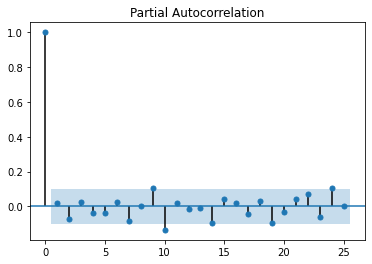

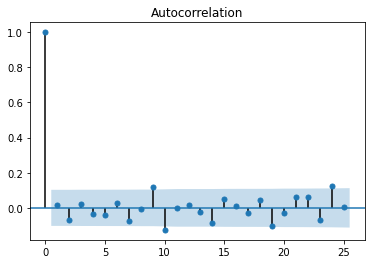

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

pacf1 = plot_pacf(df_diff_1,lags = 25) #partial autocorrelation plot
acf1 = plot_acf(df_diff_1,lags = 25) #autocorrelation plot



In [ ]:
#building the ARIMA model
#found p,q values manually from the auto correlation, and partial correlation plots;

from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(scaled_train,order = (9,1,9))

#for p, we use values that are outside the blue belt in pacf, because ones inside the blue belt, can be assumed as 0;
#for q, we do the same, but consider acf plot. here also 9 stands out, so we can use 9;
result = model.fit()

#print(result.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
test_predictions = result.forecast(testSize)

print(test_predictions)

[0.03707985 0.04067521 0.04153536 0.03923032 0.04159136 0.04159542
 0.04048551 0.0412606  0.04110431 0.04038506 0.04128684 0.04120694
 0.04083924 0.04135835 0.04114016 0.04092511 0.04123027 0.0411065
 0.04101256 0.04123325 0.04112515 0.04107595 0.04119906 0.04111288
 0.04109754 0.04117536 0.04112037 0.04111914 0.04116525 0.04112419]


In [ ]:
true_predictions = scaler.inverse_transform(test_predictions.reshape(-1,1))

df_true_predictions = pd.DataFrame(data = true_predictions, 
                  index = test.index, 
                  columns = ['Close'])

print(df_true_predictions.tail())

                   Close
Date                    
2022-11-27  20565.792776
2022-11-28  20563.097152
2022-11-29  20563.037121
2022-11-30  20565.297324
2022-12-01  20563.284702


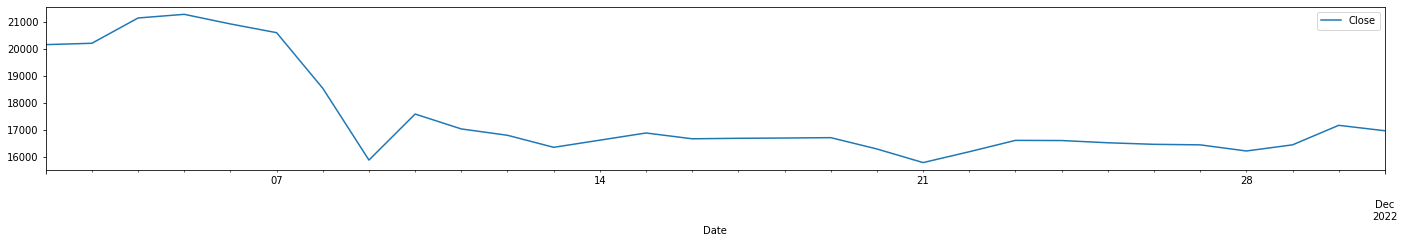

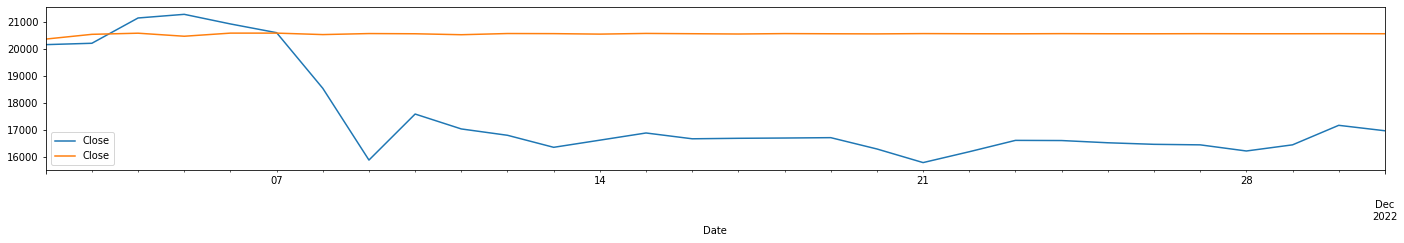

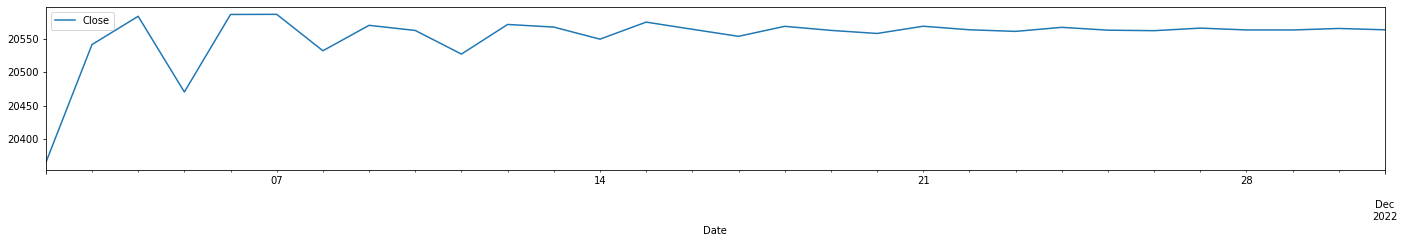

In [ ]:
test.plot(figsize = (24,3),label = 'Actual')
ax = test.plot()
df_true_predictions.plot(figsize = (24,3),label = 'Predicted')
df_true_predictions.plot(figsize = (24,3),ax=ax,label = ' Actual with Predicted')

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(test['Close'], df_true_predictions['Close']))
rms_normalized = sqrt(mean_squared_error(scaled_test,test_predictions))
print(f'RMSE : {rms}')
#print(f'RMSE Normalized: {rms_normalized}')

RMSE : 3517.312320476418
